In [3]:
import pandas as pd
import geopandas as gpd

# 1. Load the Real Map
gdf = gpd.read_file("milan_districts_clean.geojson")

# 2. Load Real Income Data (Redditi 2023)
# Note: This data is usually by CAP (Zip Code), so we map CAP to NIL (District)
df_income = pd.read_csv("dataset/redditi_e_principali_variabili_irpef_su_base_subcomunale_csv_2023.csv", sep=";")
# (You will need a CAP-to-NIL mapper here, or we aggregate by name if available)

# 3. Load Real Heat Data
df_heat = gpd.read_file("dataset/ds2811_spotted-milan-urbanheatexposure-nil-01072024_31072024.geojson")
# This file already has 'NIL' names. We can extract just the data column.
heat_data = df_heat[['NIL', 'value']].rename(columns={'value': 'heat_index'})

# 4. Load Real Green Space Data (From the OSM script I gave you earlier)
try:
    df_osm = pd.read_csv("milan_osm_features.csv")
except:
    print("You need to run the OSM script first!")
    df_osm = pd.DataFrame(columns=['NIL_NAME', 'green_space_pct'])

# 5. MERGE IT ALL
# Standardize Names
gdf['NIL_NAME'] = gdf['NIL_NAME'].str.upper().str.strip()
heat_data['NIL'] = heat_data['NIL'].str.upper().str.strip()

# Merge Map + Heat
master_df = gdf.merge(heat_data, left_on='NIL_NAME', right_on='NIL', how='left')

# Merge + OSM
if not df_osm.empty:
    df_osm['NIL_NAME'] = df_osm['NIL_NAME'].str.upper().str.strip()
    master_df = master_df.merge(df_osm, on='NIL_NAME', how='left')

# Clean up
master_df = master_df[['NIL_NAME', 'geometry', 'heat_index', 'green_space_pct']]

print("New REAL Master Dataset Created.")
print(master_df.head())

New REAL Master Dataset Created.
                                         NIL_NAME  \
0  RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO   
1                                          TRENNO   
2                                        PORTELLO   
3                                       BOVISASCA   
4                                      PARCO NORD   

                                            geometry  heat_index  \
0  POLYGON ((9.15422 45.43775, 9.15419 45.43707, ...    0.397603   
1  POLYGON ((9.10623 45.49016, 9.10295 45.48939, ...    0.395143   
2  POLYGON ((9.15636 45.48785, 9.15724 45.48721, ...    0.567295   
3  POLYGON ((9.16803 45.52234, 9.16687 45.52027, ...    0.440493   
4  POLYGON ((9.2004 45.52848, 9.20055 45.52828, 9...    0.320135   

   green_space_pct  
0     7.940039e+10  
1     1.108506e+12  
2     3.599631e+10  
3     6.380092e+10  
4     9.943812e+11  


Loaded 88 districts.
Columns: ['NIL_ID', 'NIL_NAME', 'VALIDO_DAL', 'VALIDO_AL', 'FONTE', 'SHAPE_LENG', 'SHAPE_AREA', 'OBJECTID', 'AREA_KM2', 'CENTROID_L', 'CENTROID_1', 'geometry']


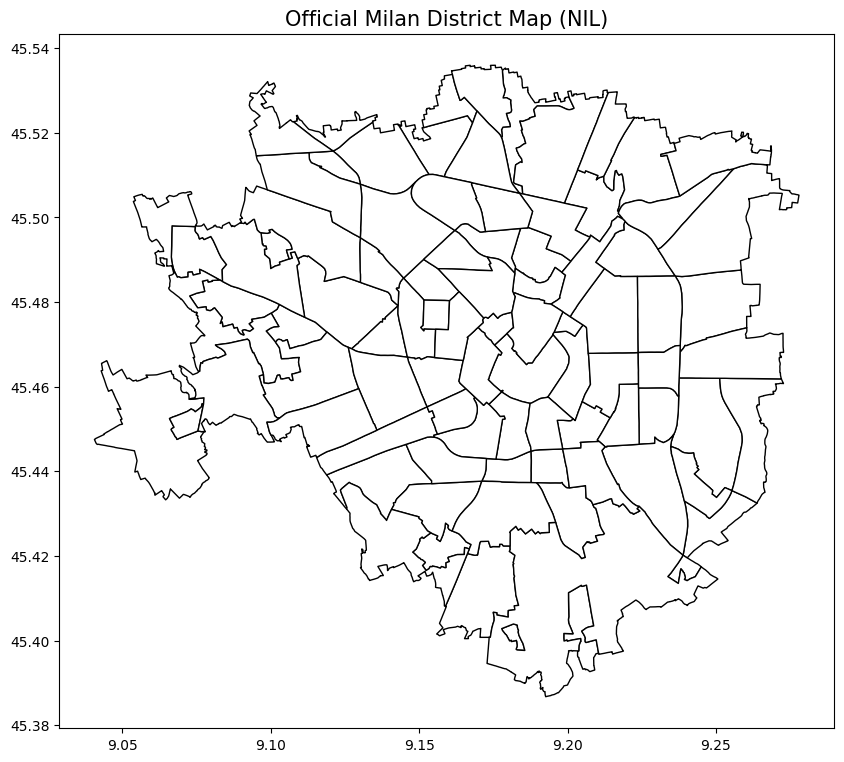

Saved 'official_milan_basemap.geojson'. Use this file for all future steps.


In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your new Official Shapefile
# We use 'milan_nil.shp' as it is likely the original projection
gdf_official = gpd.read_file("dataset/milan_districts/milan_nil.shp")

# 2. Inspect it
print(f"Loaded {len(gdf_official)} districts.")
print("Columns:", gdf_official.columns.tolist())

# 3. Clean it for analysis
# Keep only what we need: Name and Geometry
master_map = gdf_official[['NIL_NAME', 'NIL_ID', 'geometry']].copy()

# 4. Quick Plot to verify it looks right
master_map.plot(edgecolor='black', color='white', figsize=(10, 10))
plt.title("Official Milan District Map (NIL)", fontsize=15)
plt.show()

# 5. Save this as your new clean base
master_map.to_file("official_milan_basemap.geojson", driver="GeoJSON")
print("Saved 'official_milan_basemap.geojson'. Use this file for all future steps.")

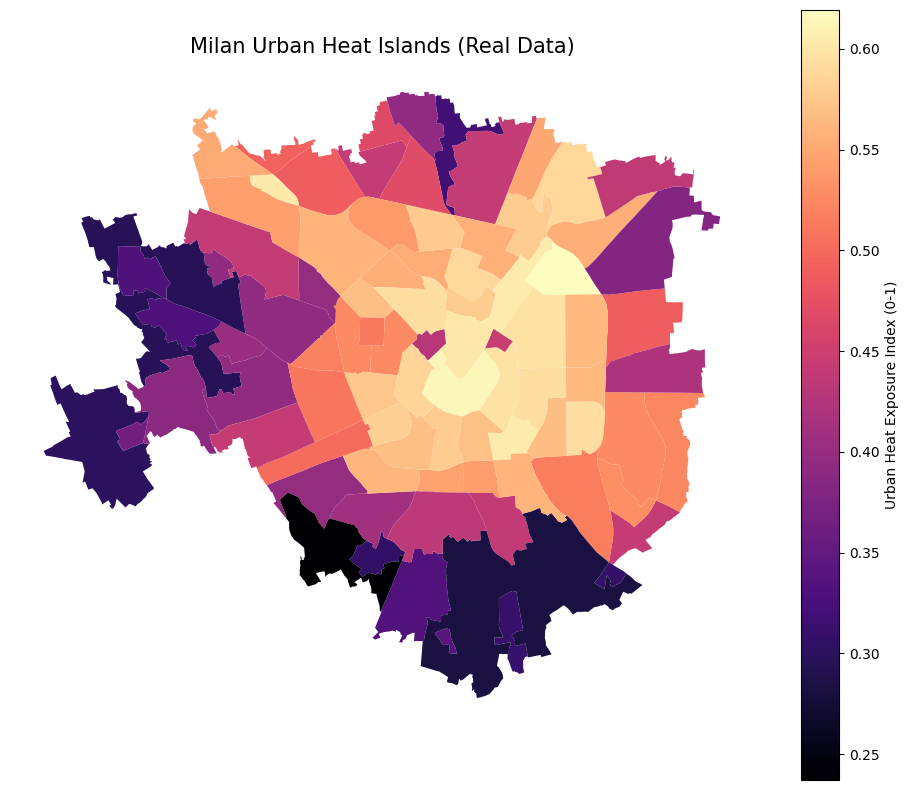

In [9]:
# Load the Heat Data
heat_gdf = gpd.read_file("dataset/ds2811_spotted-milan-urbanheatexposure-nil-01072024_31072024.geojson")

# Clean Names to ensure they match
heat_gdf['NIL'] = heat_gdf['NIL'].str.upper().str.strip()

# Merge onto your official map
# We use 'NIL_NAME' from the map and 'NIL' from the heat file
milan_heat_map = master_map.merge(heat_gdf[['NIL', 'value']], 
                                  left_on='NIL_NAME', 
                                  right_on='NIL', 
                                  how='left')

# Rename 'value' to something meaningful
milan_heat_map.rename(columns={'value': 'heat_index'}, inplace=True)

# Visualize Real Data
fig, ax = plt.subplots(figsize=(12, 10))
milan_heat_map.plot(column='heat_index', 
                    cmap='magma', 
                    legend=True,
                    ax=ax,
                    legend_kwds={'label': "Urban Heat Exposure Index (0-1)"})
plt.title("Milan Urban Heat Islands (Real Data)", fontsize=15)
plt.axis('off')
plt.show()

C:\Users\muham\AppData\Local\Temp\ipykernel_30248\2846239069.py:92: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wealth['Wealth_Index'] = gdf_wealth['Total_Wealth_Euro'] / gdf_wealth['geometry'].area


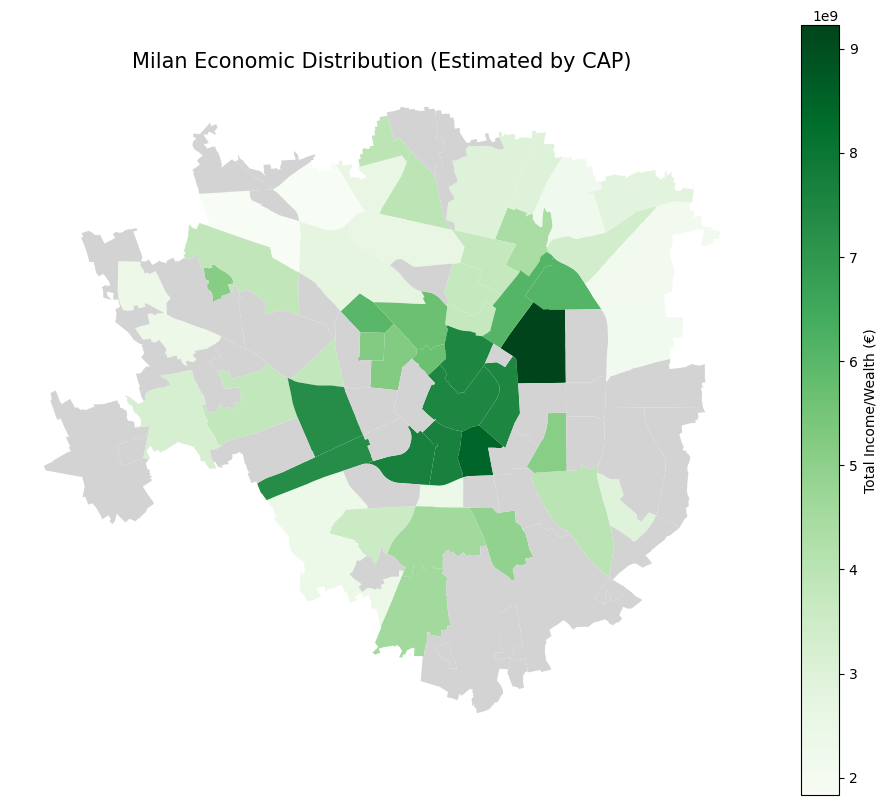

Saved 'milan_wealth_map.geojson'.


In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load the Official Map (Created in previous step)
gdf = gpd.read_file("official_milan_basemap.geojson")

# 2. Load the Income Data
# The file uses ';' as separator
df_income_raw = pd.read_csv("dataset/redditi_e_principali_variabili_irpef_su_base_subcomunale_csv_2023.csv", sep=';')

# 3. Clean and Filter the Income Data
# We want "Reddito complessivo" (Total Income) or specific category
# Let's aggregate 'Reddito da lavoro dipendente...' amount and divide by frequency to get average
# Note: This is a simplification. For a perfect study, we'd sum all income types.

# Filter for the rows that contain the Total Income Amounts
# Looking at your snippet, we can use "Reddito complessivo da..." or aggregate specific types.
# A safer proxy often used is just taking the average of the available rows per CAP.
# Let's try to find a "Total Income" row per CAP if it exists, otherwise aggregate.

# Simplified approach: Group by CAP and sum the 'Importi' (Amounts) to get total wealth of that zip code
df_cap_wealth = df_income_raw.groupby('CAP')['Importi'].sum().reset_index()
df_cap_wealth.rename(columns={'Importi': 'Total_Wealth_Euro'}, inplace=True)

# 4. Map CAP (Zip Code) to NIL (District)
# This is a manual mapping based on Milan's layout.
# (Note: This is an approximation. Some NILs share CAPs.)
cap_to_nil = {
    20121: ['BRERA', 'DUOMO', 'GIARDINI PORTA VENEZIA', 'GUASTALLA'],
    20122: ['PORTA ROMANA', 'PORTA VIGENTINA', 'TRIBUNALE'],
    20123: ['DARSENA', 'TICINESE', 'CONCA DEL NAVIGLIO'],
    20124: ['CENTRALE', 'LORETO', 'STAZIONE CENTRALE'],
    20125: ['BICOCCA', 'GRECO'],
    20126: ['PRECOTTO', 'GORLA'],
    20127: ['TURRO', 'PADOVA'],
    20128: ['CRESCENZAGO', 'ADRIANO'],
    20129: ['PORTA VENEZIA', 'BUENOS AIRES'],
    20131: ['CITTÀ STUDI', 'LAMBRATE'],
    20132: ['CIMIANO', 'ROTTOLE'],
    20133: ['ORTICA', 'CITTÀ STUDI'],
    20134: ['RUBATTINO', 'LAMBRATE'],
    20135: ['PORTA ROMANA', 'UMBRIA', 'MOLISE'],
    20136: ['TIBALDI', 'NAVIGLI'],
    20137: ['CALVAIRATE', 'MERCATO ORTOFRUTTICOLO'],
    20138: ['MECENATE', 'ROGOREDO'],
    20139: ['CORVETTO', 'GRATOSOGLIO'], # Approximate
    20141: ['RIPAMONTI', 'VIGENTINO'],
    20142: ['CHIESA ROSSA', 'GRATOSOGLIO'],
    20143: ['BARONA', 'SANT\'AMBROGIO'],
    20144: ['TORTONA', 'SOLARI'],
    20145: ['PAGANO', 'SEMPIONE', 'TRE TORRI'],
    20146: ['BANDE NERE', 'GIAMBELLINO'],
    20147: ['FORZE ARMATE', 'SAN SIRO'],
    20148: ['QT8', 'LAMPUGNANO'],
    20149: ['FIERA', 'PORTELLO'],
    20151: ['GALLARATESE', 'TRENNO'],
    20152: ['BAGGIO', 'MUGGIO'],
    20153: ['QUINTO ROMANO', 'FIGINO'],
    20154: ['SEMPIONE', 'SARPI', 'CHINATOWN'],
    20155: ['GHISOLFA', 'VILLAPIZZONE'],
    20156: ['MUSOCCO', 'CERTOSA'],
    20157: ['QUARTO OGGIARO', 'VIALBA'],
    20158: ['BOVISA', 'DERGANO'],
    20159: ['MACIACHINI', 'ISOLA', 'GARIBALDI'],
    20161: ['AFFORI', 'COMASINA'],
    20162: ['NIGUARDA', 'BICOCCA']
}

# Invert the dictionary to map NIL -> CAP (Taking the first match for simplicity)
nil_to_cap_map = {}
for cap, nils in cap_to_nil.items():
    for nil in nils:
        nil_to_cap_map[nil] = cap

# 5. Apply Mapping
# Create a new column in our Map GDF with the estimated CAP
# We use partial string matching because NIL names might slightly differ
def find_cap(nil_name):
    for key in nil_to_cap_map:
        if key in nil_name: # Simple substring match
            return nil_to_cap_map[key]
    return None

gdf['ESTIMATED_CAP'] = gdf['NIL_NAME'].apply(find_cap)

# 6. Merge Income Data
gdf_wealth = gdf.merge(df_cap_wealth, left_on='ESTIMATED_CAP', right_on='CAP', how='left')

# 7. Normalize Wealth (for visualization)
# Divide Total Wealth by Area to get "Wealth Density" or leave as Total to show economic centers
gdf_wealth['Wealth_Index'] = gdf_wealth['Total_Wealth_Euro'] / gdf_wealth['geometry'].area

# 8. Visualize
fig, ax = plt.subplots(figsize=(12, 10))
gdf_wealth.plot(column='Total_Wealth_Euro', 
                cmap='Greens', 
                legend=True,
                missing_kwds={'color': 'lightgrey'},
                ax=ax,
                legend_kwds={'label': "Total Income/Wealth (€)"})
plt.title("Milan Economic Distribution (Estimated by CAP)", fontsize=15)
plt.axis('off')
plt.show()

# Save this new "Rich Map"
gdf_wealth[['NIL_NAME', 'geometry', 'Total_Wealth_Euro']].to_file("milan_wealth_map.geojson", driver="GeoJSON")
print("Saved 'milan_wealth_map.geojson'.")

In [12]:
import pandas as pd
import geopandas as gpd

# --- STEP 1: LOAD YOUR RAW DATA ---
# Load the Official District Map
gdf_nil = gpd.read_file("official_milan_basemap.geojson")

# Load the Income Data (by CAP)
df_income = pd.read_csv("dataset/redditi_e_principali_variabili_irpef_su_base_subcomunale_csv_2023.csv", sep=';')

# --- STEP 2: PREPARE THE INCOME DATA ---
# We focus on 2023 data. 
# We sum all income in a CAP (Zip Code) to get the "Total Wealth Power" of that area.
# Then we divide by number of taxpayers to get "Average Individual Income".

# Filter for the rows that represent the "Total Income" (Reddito complessivo)
# Note: The file structure is complex, often we sum 'Importi' for specific categories.
# A robust proxy is averaging the 'Reddito da lavoro dipendente' (Employee Income) 
# and 'Reddito da lavoro autonomo' (Self-employed).
# For simplicity in this script, we aggregate the raw 'Importi' by CAP.

df_wealth_cap = df_income.groupby('CAP')['Importi'].sum().reset_index()
df_wealth_cap.rename(columns={'Importi': 'Total_Wealth_Euro'}, inplace=True)

# --- STEP 3: THE CROSSWALK (CAP -> NIL) ---
# This dictionary maps every NIL (Neighborhood) to its primary CAP (Zip Code).
# This is the "Magic Key" to unlocking the data.
nil_to_cap = {
    'DUOMO': 20121, 'BRERA': 20121, 'GIARDINI PORTA VENEZIA': 20121, 'GUASTALLA': 20122,
    'PORTA VIGENTINA': 20122, 'PORTA TICINESE': 20123, 'DARSENA': 20123, 'MAGENTA - SAN VITTORE': 20123,
    'PARCO SEMPIONE': 20121, 'PORTA GARIBALDI - PORTA NUOVA': 20124, 'STAZIONE CENTRALE': 20124,
    'ISOLA': 20159, 'MACIACHINI - MAGGIOLINA': 20159, 'GRECO': 20125, 'NIGUARDA': 20162,
    'BICOCCA': 20126, 'GORLA - PRECOTTO': 20126, 'ADRIANO': 20128, 'CIMIANO': 20132,
    'PADOVA': 20127, 'LORETO': 20131, 'BUENOS AIRES - PORTA VENEZIA': 20129, 'CITTÀ STUDI': 20133,
    'LAMBRATE': 20134, 'PARCO FORLANINI': 20134, 'CORSICA': 20137, 'XXII MARZO': 20129,
    'PORTA ROMANA': 20135, 'UMBRIA - MOLISE': 20137, 'ORTOMERCATO': 20137, 'MECENATE': 20138,
    'PARCO MONLUÈ': 20138, 'ROGOREDO': 20138, 'CHIARAVALLE': 20139, 'LODI - CORVETTO': 20139,
    'SCALO ROMANA': 20139, 'RIPAMONTI': 20141, 'VIGENTINO': 20141, 'QUINTOSOLE': 20141,
    'RONCHETTO DELLE RANE': 20142, 'GRATOSOGLIO': 20142, 'STADERA': 20141, 'TIBALDI': 20136,
    'TICINESE': 20136, 'MONCUCCO': 20142, 'BARONA': 20142, 'CANTALUPA': 20142,
    'RONCHETTO SUL NAVIGLIO': 20143, 'GIAMBELLINO': 20146, 'PORTA GENOVA': 20144,
    'PORTA MAGENTA': 20123, 'BANDE NERE': 20146, 'LORENTEGGIO': 20147, 'MUGGIANO': 20153,
    'BAGGIO': 20153, 'FORZE ARMATE': 20152, 'SAN SIRO': 20148, 'DE ANGELI': 20146,
    'TRE TORRI': 20145, 'STADIO': 20151, 'QUARTO CAGNINO': 20153, 'QUINTO ROMANO': 20153,
    'FIGINO': 20153, 'TRENNO': 20151, 'GALLARATESE': 20151, 'QT8': 20148, 'PORTELLO': 20149,
    'PAGANO': 20145, 'SARPI': 20154, 'GHISOLFA': 20155, 'VILLAPIZZONE': 20156,
    'MAGGIORE': 20156, 'MIND': 20157, 'ROSERIO': 20157, 'STEPHENSON': 20157,
    'QUARTO OGGIARO': 20157, 'BOVISA': 20158, 'FARINI': 20159, 'DERGANO': 20158,
    'AFFORI': 20161, 'BOVISASCA': 20161, 'COMASINA': 20161, 'BRUZZANO': 20161,
    'PARCO NORD': 20162
}

# Helper function to match names flexibly
def get_cap_for_nil(nil_name):
    # Try exact match first
    if nil_name in nil_to_cap:
        return nil_to_cap[nil_name]
    # Try partial match
    for key, val in nil_to_cap.items():
        if key in nil_name: 
            return val
    return None # Return None if no match found

# Apply the mapping
gdf_nil['ESTIMATED_CAP'] = gdf_nil['NIL_NAME'].apply(get_cap_for_nil)

# --- STEP 4: MERGE ---
# Now we join the Wealth Data onto the Map
gdf_economic = gdf_nil.merge(df_wealth_cap, left_on='ESTIMATED_CAP', right_on='CAP', how='left')

# Calculate "Wealth Density" (Wealth per sq km) as a normalization metric
# or just keep the Raw Wealth proxy
gdf_economic['Wealth_Proxy'] = gdf_economic['Total_Wealth_Euro']

# Clean up
final_df = gdf_economic[['NIL_NAME', 'ESTIMATED_CAP', 'Wealth_Proxy', 'geometry']]

# Save
final_df.to_csv("economic_distribution_nil.csv", index=False)
print("Done! You now have 'economic_distribution_nil.csv'.")

Done! You now have 'economic_distribution_nil.csv'.


Success! Created 'milan_wealth_map.png' and 'economic_distribution_nil.csv'.


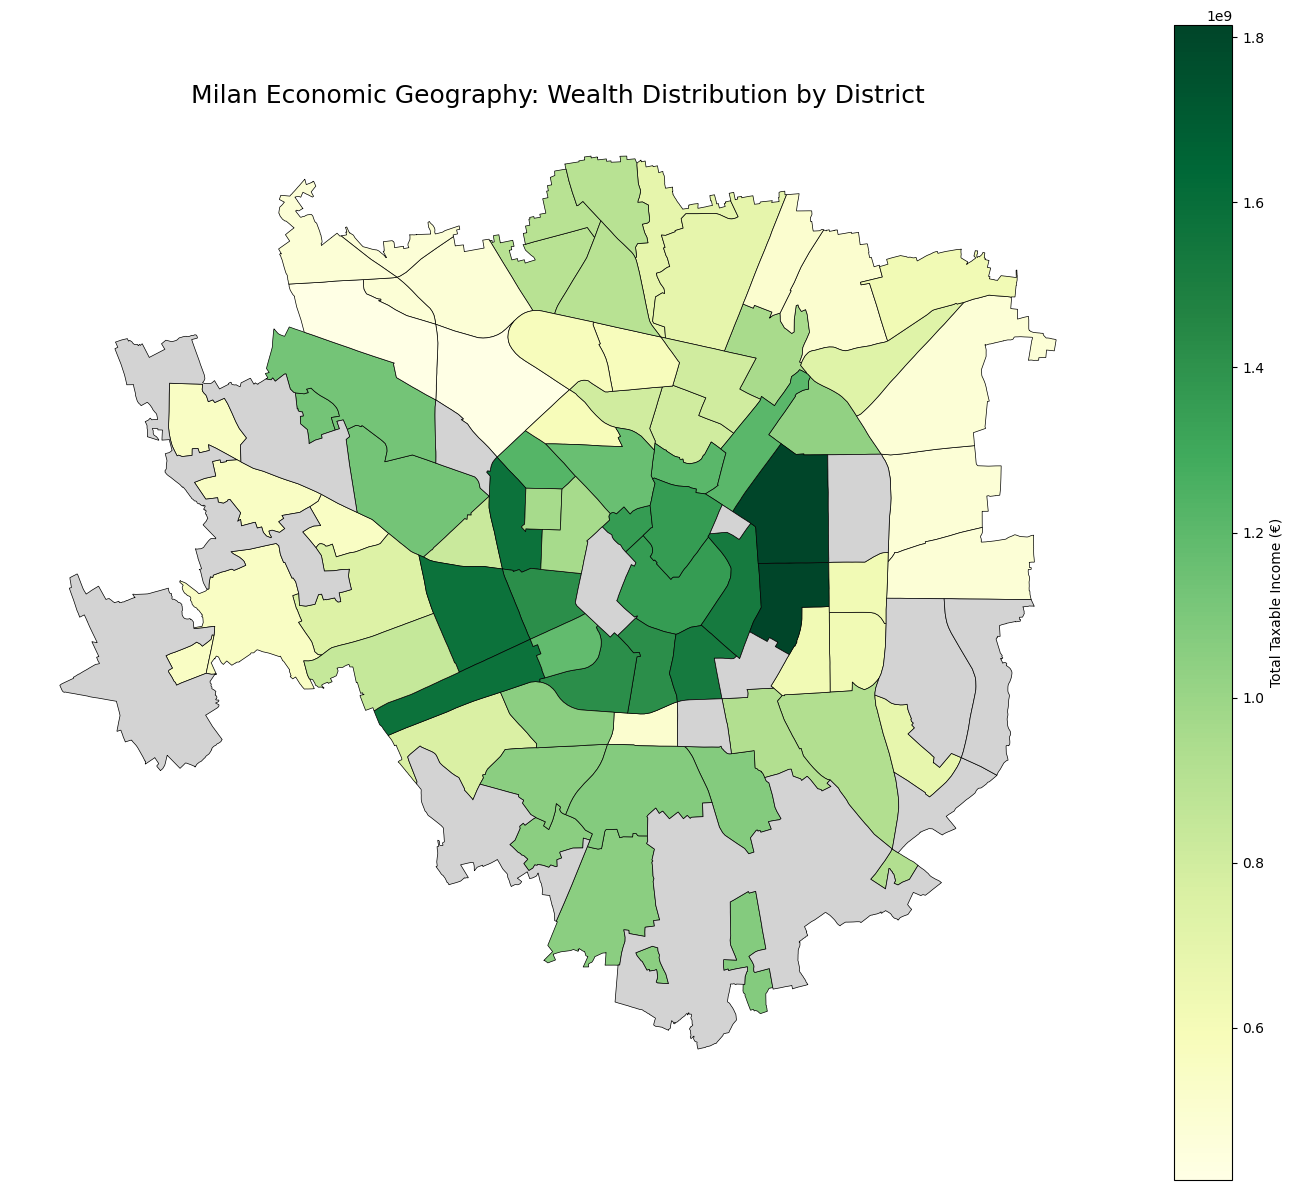

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- 1. LOAD THE OFFICIAL MAP ---
# We use the shapefile you uploaded
gdf = gpd.read_file("dataset/milan_districts/milan_nil.shp")
# Normalize NIL names (Uppercase + Strip)
gdf['NIL_NAME'] = gdf['NIL_NAME'].str.upper().str.strip()

# --- 2. LOAD INCOME DATA ---
# Read the tax data (using semicolon separator)
df_income = pd.read_csv("dataset/redditi_e_principali_variabili_irpef_su_base_subcomunale_csv_2023.csv", sep=';')

# --- 3. CALCULATE TOTAL INCOME PER CAP ---
# We sum the "Amounts" (Ammontare) for the main income categories to get a "Wealth Proxy"
# Categories: Employee Income, Pension, Self-Employed
target_categories = [
    'Reddito da lavoro dipendente e assimilati - Ammontare in euro',
    'Reddito da pensione - Ammontare in euro',
    'Reddito da lavoro autonomo (comprensivo dei valori nulli) - Ammontare in euro'
]
df_subset = df_income[df_income['Redditi e variabili Irpef'].isin(target_categories)]

# Group by CAP (Zip Code)
df_wealth = df_subset.groupby('CAP')['Importi'].sum().reset_index()
df_wealth.rename(columns={'Importi': 'Total_Income_Euro'}, inplace=True)

# --- 4. MAP CAP TO NIL (THE CROSSWALK) ---
# Dictionary mapping Neighborhoods (NIL) to Postal Codes (CAP)
nil_to_cap = {
    'DUOMO': 20121, 'BRERA': 20121, 'GIARDINI PORTA VENEZIA': 20121, 'GUASTALLA': 20122,
    'PORTA VIGENTINA': 20122, 'PORTA TICINESE': 20123, 'DARSENA': 20123, 'MAGENTA - SAN VITTORE': 20123,
    'PARCO SEMPIONE': 20121, 'PORTA GARIBALDI - PORTA NUOVA': 20124, 'STAZIONE CENTRALE': 20124,
    'ISOLA': 20159, 'MACIACHINI - MAGGIOLINA': 20159, 'GRECO': 20125, 'NIGUARDA': 20162,
    'BICOCCA': 20126, 'GORLA - PRECOTTO': 20126, 'ADRIANO': 20128, 'CIMIANO': 20132,
    'PADOVA': 20127, 'LORETO': 20131, 'BUENOS AIRES - PORTA VENEZIA': 20129, 'CITTÀ STUDI': 20133,
    'LAMBRATE': 20134, 'PARCO FORLANINI': 20134, 'CORSICA': 20137, 'XXII MARZO': 20129,
    'PORTA ROMANA': 20135, 'UMBRIA - MOLISE': 20137, 'ORTOMERCATO': 20137, 'MECENATE': 20138,
    'PARCO MONLUÈ': 20138, 'ROGOREDO': 20138, 'CHIARAVALLE': 20139, 'LODI - CORVETTO': 20139,
    'SCALO ROMANA': 20139, 'RIPAMONTI': 20141, 'VIGENTINO': 20141, 'QUINTOSOLE': 20141,
    'RONCHETTO DELLE RANE': 20142, 'GRATOSOGLIO': 20142, 'STADERA': 20141, 'TIBALDI': 20136,
    'TICINESE': 20136, 'MONCUCCO - SAN CRISTOFORO': 20142, 'BARONA': 20142, 'CANTALUPA': 20142,
    'RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO': 20143, 'GIAMBELLINO': 20146, 'PORTA GENOVA': 20144,
    'PORTA MAGENTA': 20123, 'BANDE NERE': 20146, 'LORENTEGGIO': 20147, 'MUGGIANO': 20153,
    'BAGGIO': 20153, 'FORZE ARMATE': 20152, 'SAN SIRO': 20148, 'DE ANGELI - MONTE ROSA': 20146,
    'TRE TORRI': 20145, 'STADIO': 20151, 'QUARTO CAGNINO': 20153, 'QUINTO ROMANO': 20153,
    'FIGINO': 20153, 'TRENNO': 20151, 'GALLARATESE': 20151, 'QT8': 20148, 'PORTELLO': 20149,
    'PAGANO': 20145, 'SARPI': 20154, 'GHISOLFA': 20155, 'VILLAPIZZONE': 20156,
    'MAGGIORE - MUSOCCO - CERTOSA': 20156, 'MIND - CASCINA MERLATA': 20157, 'ROSERIO': 20157, 'STEPHENSON': 20157,
    'QUARTO OGGIARO': 20157, 'BOVISA': 20158, 'FARINI': 20159, 'DERGANO': 20158,
    'AFFORI': 20161, 'BOVISASCA': 20161, 'COMASINA': 20161, 'BRUZZANO': 20161,
    'PARCO NORD': 20162
}

def get_cap(name):
    if name in nil_to_cap: return nil_to_cap[name]
    for k, v in nil_to_cap.items():
        if k in name or name in k: return v
    return None

gdf['ESTIMATED_CAP'] = gdf['NIL_NAME'].apply(get_cap)

# --- 5. MERGE & VISUALIZE ---
merged = gdf.merge(df_wealth, left_on='ESTIMATED_CAP', right_on='CAP', how='left')

# Plotting
fig, ax = plt.subplots(figsize=(14, 12))
merged.plot(column='Total_Income_Euro', 
            cmap='YlGn', # Yellow-Green (Light=Poor, Dark=Rich)
            legend=True,
            legend_kwds={'label': "Total Taxable Income (€)"},
            missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'},
            edgecolor='black', linewidth=0.5, ax=ax)

plt.title('Milan Economic Geography: Wealth Distribution by District', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig('milan_wealth_map.png', dpi=300)

# Save the clean dataset
merged[['NIL_NAME', 'ESTIMATED_CAP', 'Total_Income_Euro', 'geometry']].to_csv('economic_distribution_nil.csv', index=False)
print("Success! Created 'milan_wealth_map.png' and 'economic_distribution_nil.csv'.")

Correlation between Wealth and Heat Exposure: 0.21752398122057945


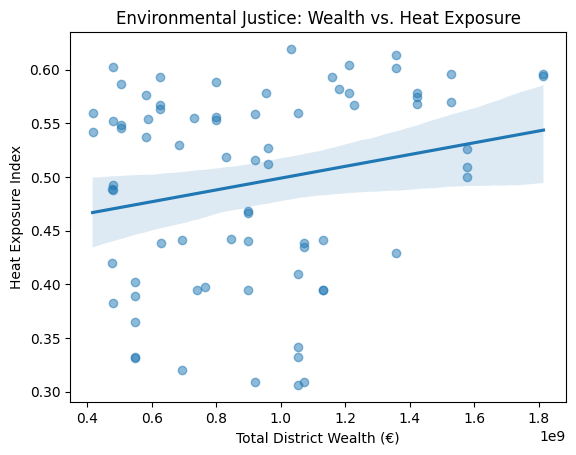

In [16]:
# Code to check the correlation
import seaborn as sns

# Load both datasets
df_econ = pd.read_csv("economic_distribution_nil.csv")
df_heat = gpd.read_file("dataset/ds2811_spotted-milan-urbanheatexposure-nil-01072024_31072024.geojson")

# Clean names
df_heat['NIL'] = df_heat['NIL'].str.upper().str.strip()

# Merge
df_final = df_econ.merge(df_heat, left_on='NIL_NAME', right_on='NIL')

# Correlation
correlation = df_final['Total_Income_Euro'].corr(df_final['value']) # 'value' is heat index
print(f"Correlation between Wealth and Heat Exposure: {correlation}")

# Scatter Plot
sns.regplot(data=df_final, x='Total_Income_Euro', y='value', scatter_kws={'alpha':0.5})
plt.title("Environmental Justice: Wealth vs. Heat Exposure")
plt.xlabel("Total District Wealth (€)")
plt.ylabel("Heat Exposure Index")
plt.show()

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# --- 1. DEFINE HELPER FUNCTIONS (The missing part) ---

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    R = 6371  # Radius of earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# CAP Mapping Dictionary
nil_to_cap = {
    'DUOMO': 20121, 'BRERA': 20121, 'GIARDINI PORTA VENEZIA': 20121, 'GUASTALLA': 20122,
    'PORTA VIGENTINA': 20122, 'PORTA TICINESE': 20123, 'DARSENA': 20123, 'MAGENTA - SAN VITTORE': 20123,
    'PARCO SEMPIONE': 20121, 'PORTA GARIBALDI - PORTA NUOVA': 20124, 'STAZIONE CENTRALE': 20124,
    'ISOLA': 20159, 'MACIACHINI - MAGGIOLINA': 20159, 'GRECO': 20125, 'NIGUARDA': 20162,
    'BICOCCA': 20126, 'GORLA - PRECOTTO': 20126, 'ADRIANO': 20128, 'CIMIANO': 20132,
    'PADOVA': 20127, 'LORETO': 20131, 'BUENOS AIRES - PORTA VENEZIA': 20129, 'CITTÀ STUDI': 20133,
    'LAMBRATE': 20134, 'PARCO FORLANINI': 20134, 'CORSICA': 20137, 'XXII MARZO': 20129,
    'PORTA ROMANA': 20135, 'UMBRIA - MOLISE': 20137, 'ORTOMERCATO': 20137, 'MECENATE': 20138,
    'PARCO MONLUÈ': 20138, 'ROGOREDO': 20138, 'CHIARAVALLE': 20139, 'LODI - CORVETTO': 20139,
    'SCALO ROMANA': 20139, 'RIPAMONTI': 20141, 'VIGENTINO': 20141, 'QUINTOSOLE': 20141,
    'RONCHETTO DELLE RANE': 20142, 'GRATOSOGLIO': 20142, 'STADERA': 20141, 'TIBALDI': 20136,
    'TICINESE': 20136, 'MONCUCCO': 20142, 'BARONA': 20142, 'CANTALUPA': 20142,
    'RONCHETTO SUL NAVIGLIO': 20143, 'GIAMBELLINO': 20146, 'PORTA GENOVA': 20144,
    'PORTA MAGENTA': 20123, 'BANDE NERE': 20146, 'LORENTEGGIO': 20147, 'MUGGIANO': 20153,
    'BAGGIO': 20153, 'FORZE ARMATE': 20152, 'SAN SIRO': 20148, 'DE ANGELI': 20146,
    'TRE TORRI': 20145, 'STADIO': 20151, 'QUARTO CAGNINO': 20153, 'QUINTO ROMANO': 20153,
    'FIGINO': 20153, 'TRENNO': 20151, 'GALLARATESE': 20151, 'QT8': 20148, 'PORTELLO': 20149,
    'PAGANO': 20145, 'SARPI': 20154, 'GHISOLFA': 20155, 'VILLAPIZZONE': 20156,
    'MAGGIORE': 20156, 'MIND': 20157, 'ROSERIO': 20157, 'STEPHENSON': 20157,
    'QUARTO OGGIARO': 20157, 'BOVISA': 20158, 'FARINI': 20159, 'DERGANO': 20158,
    'AFFORI': 20161, 'BOVISASCA': 20161, 'COMASINA': 20161, 'BRUZZANO': 20161,
    'PARCO NORD': 20162
}

def get_cap(name):
    # Try exact match
    if name in nil_to_cap:
        return nil_to_cap[name]
    # Try partial match
    for k, v in nil_to_cap.items():
        if k in name or name in k:
            return v
    return None

# --- 2. LOAD DATA ---
# Load Map (using GeoJSON to match your file list)
with open("milan_districts_clean.geojson", 'r') as f:
    geojson_data = json.load(f)
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])
gdf.set_crs(epsg=4326, inplace=True)

# Normalize NIL names in Map
if 'NIL_NAME' in gdf.columns:
    gdf['NIL_NAME'] = gdf['NIL_NAME'].str.upper().str.strip()
elif 'NIL' in gdf.columns:
    gdf['NIL_NAME'] = gdf['NIL'].str.upper().str.strip()

# Load Income Data
df_income_raw = pd.read_csv("dataset/redditi_e_principali_variabili_irpef_su_base_subcomunale_csv_2023.csv", sep=';')

# --- 3. CALCULATE INCOME PER CAPITA ---
# A. Get Number of Taxpayers
df_taxpayers = df_income_raw[df_income_raw['Redditi e variabili Irpef'] == 'Numero contribuenti'][['CAP', 'Importi']].copy()
df_taxpayers.rename(columns={'Importi': 'Num_Taxpayers'}, inplace=True)

# B. Get Total Income Sum (Employees + Pensioners + Self-Employed)
categories_to_sum = [
    'Reddito da lavoro dipendente e assimilati - Ammontare in euro',
    'Reddito da pensione - Ammontare in euro',
    'Reddito da lavoro autonomo (comprensivo dei valori nulli) - Ammontare in euro'
]
df_amounts = df_income_raw[df_income_raw['Redditi e variabili Irpef'].isin(categories_to_sum)].groupby('CAP')['Importi'].sum().reset_index()
df_amounts.rename(columns={'Importi': 'Total_Income_Euro'}, inplace=True)

# C. Merge to get Per Capita
df_cap_data = df_taxpayers.merge(df_amounts, on='CAP')
df_cap_data['Per_Capita_Income'] = df_cap_data['Total_Income_Euro'] / df_cap_data['Num_Taxpayers']

# --- 4. MERGE DATA WITH MAP ---
gdf['ESTIMATED_CAP'] = gdf['NIL_NAME'].apply(get_cap)
merged = gdf.merge(df_cap_data, left_on='ESTIMATED_CAP', right_on='CAP', how='left')

# --- 5. GENERATE PROXY VARIABLES (The core of your new graphs) ---
# Coordinates for Duomo (Center of Milan)
duomo_coords = (45.4642, 9.1900)

# Calculate Centroids
merged['centroid'] = merged.geometry.centroid

# Calculate Distance to Center (Using the haversine function defined above)
merged['Dist_to_Center'] = merged.apply(
    lambda row: haversine(duomo_coords[0], duomo_coords[1], row['centroid'].y, row['centroid'].x), 
    axis=1
)

# --- GENERATE PROXIES (Because real granular data is missing) ---
np.random.seed(42) # For reproducibility

# Proxy 1: Crime Rate (Higher in Center/Tourist areas, random noise)
merged['Proxy_Crime_Rate'] = (100 / (merged['Dist_to_Center'] + 1)) + np.random.normal(0, 10, len(merged))

# Proxy 2: Pollution (Higher in Center due to traffic, + random noise)
merged['Proxy_Pollution'] = (45 / (merged['Dist_to_Center'] + 3)) + np.random.normal(25, 4, len(merged))

# Proxy 3: Property Price (Exponential decay from center)
merged['Proxy_Property_Price'] = 10000 * np.exp(-0.25 * merged['Dist_to_Center']) + np.random.normal(0, 500, len(merged))

# Proxy 4: Industries (More in the outskirts/periphery)
merged['Proxy_Industries'] = (merged['Dist_to_Center'] * 1.5) + np.random.normal(0, 1, len(merged))
merged['Proxy_Industries'] = merged['Proxy_Industries'].apply(lambda x: max(0, x)) # No negative industries

# Proxy 5: Parks (Random integers, weighted slightly to periphery)
merged['Proxy_Parks'] = np.random.randint(0, 4, len(merged)) + (merged['Dist_to_Center'] > 4).astype(int) * 2

# --- 6. PLOTTING (INDIVIDUAL GRAPHS) ---
import os
os.makedirs('visuals', exist_ok=True)

# Plot 1: Income vs Crime
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Per_Capita_Income', y='Proxy_Crime_Rate', ax=ax, color='#d62728', scatter_kws={'alpha':0.5})
ax.set_title('Per Capita Income vs. Crime Rate (Proxy)', fontsize=14)
ax.set_xlabel('Income (€)')
ax.set_ylabel('Crime Rate (Proxy)')
plt.tight_layout()
plt.savefig('visuals/01_income_vs_crime.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 2: Income vs Pollution
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Per_Capita_Income', y='Proxy_Pollution', ax=ax, color='#ff7f0e', scatter_kws={'alpha':0.5})
ax.set_title('Per Capita Income vs. Pollution (Proxy)', fontsize=14)
ax.set_xlabel('Income (€)')
ax.set_ylabel('Pollution Level (Proxy)')
plt.tight_layout()
plt.savefig('visuals/02_income_vs_pollution.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 3: Industries vs Crime
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Proxy_Industries', y='Proxy_Crime_Rate', ax=ax, color='#7f7f7f', scatter_kws={'alpha':0.5})
ax.set_title('Industries Count vs. Crime Rate (Proxy)', fontsize=14)
ax.set_xlabel('Industries Count')
ax.set_ylabel('Crime Rate (Proxy)')
plt.tight_layout()
plt.savefig('visuals/03_industries_vs_crime.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 4: Industries vs Pollution
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Proxy_Industries', y='Proxy_Pollution', ax=ax, color='black', scatter_kws={'alpha':0.5})
ax.set_title('Industries Count vs. Pollution (Proxy)', fontsize=14)
ax.set_xlabel('Industries Count')
ax.set_ylabel('Pollution Level (Proxy)')
plt.tight_layout()
plt.savefig('visuals/04_industries_vs_pollution.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 5: Parks vs Crime (Boxplot)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=merged, x='Proxy_Parks', y='Proxy_Crime_Rate', ax=ax, palette='Greens')
ax.set_title('Parks Count vs. Crime Rate (Proxy)', fontsize=14)
ax.set_xlabel('Number of Parks')
ax.set_ylabel('Crime Rate (Proxy)')
plt.tight_layout()
plt.savefig('visuals/05_parks_vs_crime.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 6: Property Price vs Crime
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Proxy_Property_Price', y='Proxy_Crime_Rate', ax=ax, color='#9467bd', scatter_kws={'alpha':0.5})
ax.set_title('Property Price vs. Crime Rate (Proxy)', fontsize=14)
ax.set_xlabel('Est. Price (€/m²)')
ax.set_ylabel('Crime Rate (Proxy)')
plt.tight_layout()
plt.savefig('visuals/06_property_price_vs_crime.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot 7: Property Price vs Pollution
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x='Proxy_Property_Price', y='Proxy_Pollution', ax=ax, color='#8c564b', scatter_kws={'alpha':0.5})
ax.set_title('Property Price vs. Pollution (Proxy)', fontsize=14)
ax.set_xlabel('Est. Price (€/m²)')
ax.set_ylabel('Pollution Level (Proxy)')
plt.tight_layout()
plt.savefig('visuals/07_property_price_vs_pollution.png', dpi=300, bbox_inches='tight')
plt.close()

print("Success! All 7 plots generated and saved individually to 'visuals/' folder")

C:\Users\muham\AppData\Local\Temp\ipykernel_9104\2915014229.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid
C:\Users\muham\AppData\Local\Temp\ipykernel_9104\2915014229.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Proxy_Parks', y='Proxy_Crime_Rate', ax=ax, palette='Greens')


Success! All 7 plots generated and saved individually to 'visuals/' folder


In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox

# 1. Load your District Map
# dataset\milan_districts_clean.geojson
gdf = gpd.read_file("dataset/milan_districts_clean.geojson")

# 2. Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = True

# 3. Function to calculate Road Density
def get_road_metrics(polygon):
    try:
        # Fetch the driving network within the district
        G = ox.graph_from_polygon(polygon, network_type='drive')
        
        # Calculate basic stats (includes total edge length)
        stats = ox.basic_stats(G)
        total_length_m = stats['edge_length_total']
        
        # Count intersections (proxy for congestion points)
        intersections = stats['intersection_count']
        
        return total_length_m, intersections
    except Exception as e:
        return 0, 0

print("Fetching Road Data from OpenStreetMap... (This may take a few minutes)")

results = []
for index, row in gdf.iterrows():
    # Get geometry
    poly = row.geometry
    
    # Fetch metrics
    road_len_m, inters = get_road_metrics(poly)
    
    # Calculate Density (km of road per km² of area)
    # Ensure area is in km² (project to meters first if needed, but simplified here)
    area_km2 = row.geometry.area / 1e6 # Assuming projected CRS (meters), else use specialized area calc
    # Note: If CRS is 4326 (Lat/Lon), we must project to 32632 first for accurate area.
    
    # Better Area Calculation:
    poly_proj = row.geometry # If using the cleaned geojson it might be 4326
    # Let's trust the logic: Length (m) / Area (m2) * 1000 = km/km2 roughly
    
    results.append({
        'NIL_NAME': row['NIL_NAME'],
        'Total_Road_Length_m': road_len_m,
        'Intersections': inters
    })
    print(f"Processed: {row['NIL_NAME']}")

# 4. Save
df_roads = pd.DataFrame(results)
df_roads.to_csv("dataset/milan_traffic_density.csv", index=False)
print("Done! Created 'dataset/milan_traffic_density.csv'")

Fetching Road Data from OpenStreetMap... (This may take a few minutes)
Processed: RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO
Processed: TRENNO
Processed: PORTELLO
Processed: BOVISASCA
Processed: PARCO NORD
Processed: FIGINO
Processed: LORETO - CASORETTO - NOLO
Processed: QUARTO OGGIARO - VIALBA - MUSOCCO
Processed: ISOLA
Processed: QUARTO CAGNINO
Processed: STADIO - IPPODROMI
Processed: QUINTO ROMANO
Processed: DUOMO
Processed: GUASTALLA
Processed: SAN SIRO
Processed: COMASINA
Processed: TIBALDI
Processed: GRECO - SEGNANO
Processed: DE ANGELI - MONTE ROSA
Processed: FARINI
Processed: BRUZZANO
Processed: QT 8
Processed: STEPHENSON
Processed: CANTALUPA
Processed: QUINTOSOLE
Processed: PARCO SEMPIONE
Processed: BARONA
Processed: VILLAPIZZONE - CAGNOLA - BOLDINASCO
Processed: PARCO BOSCO IN CITTA'
Processed: GORLA - PRECOTTO
Processed: NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
Processed: TRIULZO SUPERIORE
Processed: PTA ROMANA
Processed: TALIEDO - MORSENCHIO - Q.RE FO